# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?


# 4.1 Evaluation metrics: session overview 

* Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
* https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv


*Metric* - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)


In [3]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [4]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [5]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [6]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

# 4.2 Accuracy and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [7]:
len(y_val)

1409

In [9]:
(y_val == churn_decision).sum()

1132

In [10]:
(y_val == churn_decision).mean()

0.8034066713981547

In [11]:
1132 / 1409

0.8034066713981547

In [17]:
from sklearn.metrics import accuracy_score

In [19]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [20]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    # churn_decision = (y_pred >= t)
    # score = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


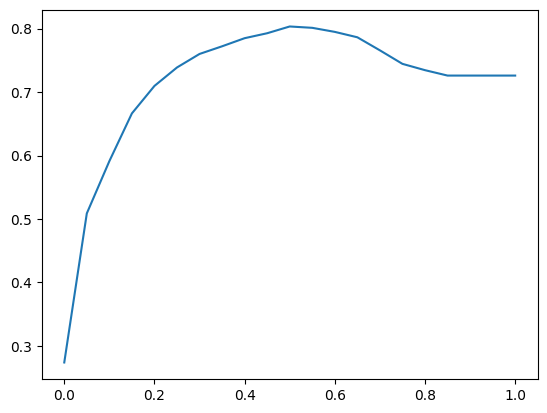

In [21]:
plt.plot(thresholds, scores)

In [22]:
from collections import Counter

In [23]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

We can observe that there are significantly more non-churning customers than churning ones, with only 27% being churning customers and 73% being non-churning customers. This situation highlights a common challenge known as class imbalance, where one class has far more samples than the other.

In [25]:
y_val.mean()

0.2739531582682754

In [24]:
1 - y_val.mean()

0.7260468417317246

# 4.3 Confusion table

- Different types of errors and correct decisions
- Arranging them in a table

In [26]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [27]:
t = 0.5

predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)


In [32]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [34]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [36]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [39]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

# 4.4 Precision and Recall

In [41]:
(tp + tn) / (tp + tn + fp + fn)

0.8034066713981547

In [42]:
p = tp / (tp + fp)
p


In [44]:
tp + fp

311

In [45]:
r = tp / (tp + fn)
r

0.5440414507772021

In [46]:
tp + fn

386

# 4.5 ROC Curves

### TPR and FPR

In [47]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [48]:
fpr = fp / (fp + tn)
fpr

0.09872922776148582

In [49]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))
    


In [55]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [56]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)


In [57]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.948187,0.543500
20,0.2,333,356,53,667,0.862694,0.347996
30,0.3,284,236,102,787,0.735751,0.230694
40,0.4,249,166,137,857,0.645078,0.162268
50,0.5,210,101,176,922,0.544041,0.098729
60,0.6,150,53,236,970,0.388601,0.051808
70,0.7,76,20,310,1003,0.196891,0.019550
80,0.8,13,1,373,1022,0.033679,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


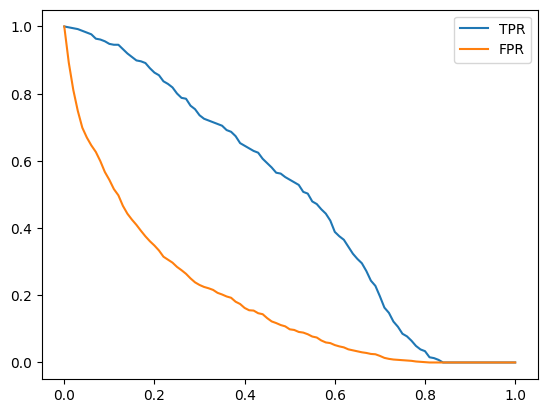

In [58]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()


### Random model

In [73]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [61]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [77]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
        
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        
        scores.append((t, tp, fp, fn, tn))
        
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [78]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

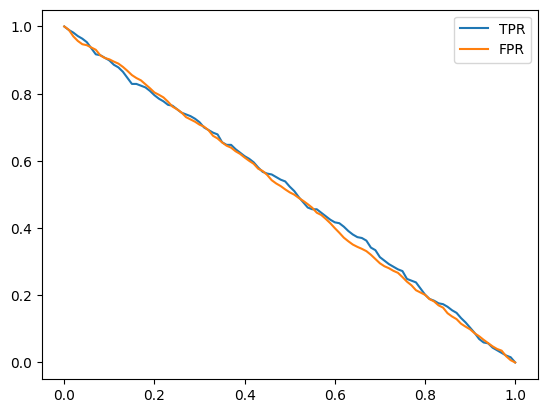

In [96]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

### Ideal model

In [81]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [82]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [88]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [86]:
1 - y_val.mean()

0.7260468417317246

In [89]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [90]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

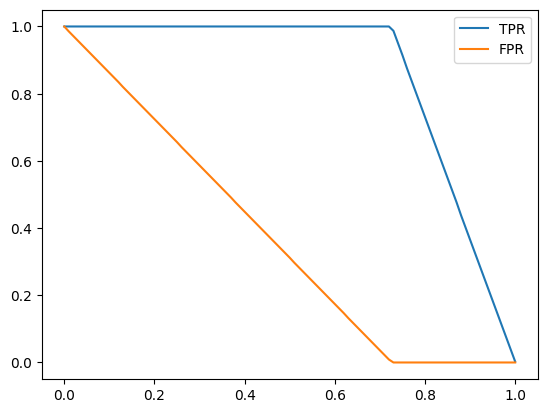

In [95]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

### Putting everthing together

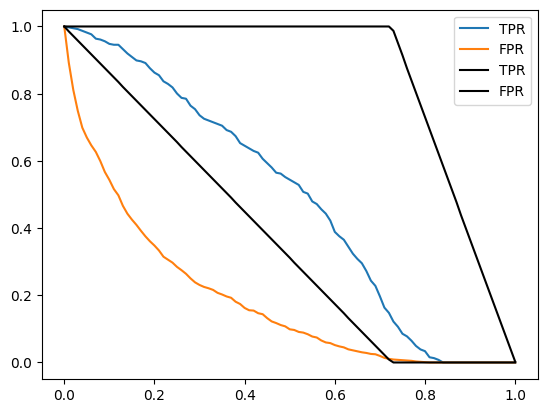

In [94]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR', color='black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR', color='black')

plt.legend()

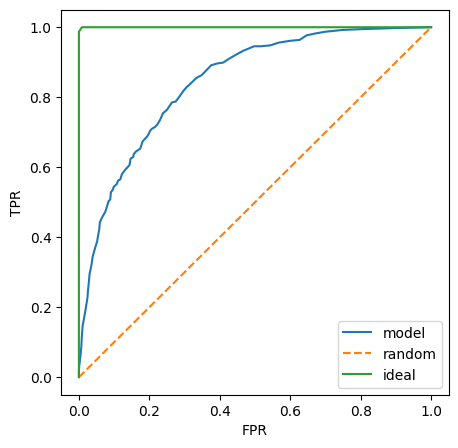

In [102]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0, 1], [0, 1], label='random', linestyle='--')
# plt.plot(df_rand.fpr, df_rand.tpr, label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()


In [103]:
from sklearn.metrics import roc_curve

In [104]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

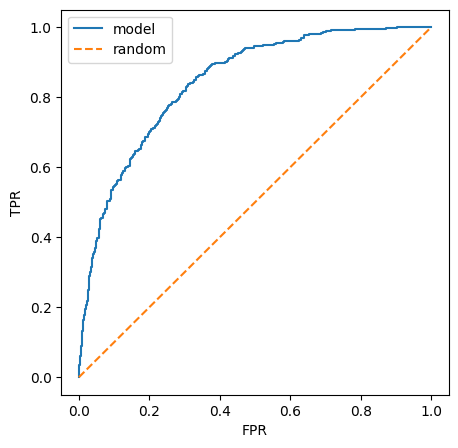

In [105]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='model')
plt.plot([0, 1], [0, 1], label='random', linestyle='--')
# plt.plot(df_rand.fpr, df_rand.tpr, label='random')
# plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()


# 4.6 ROC AUC
- Area under the ROC curve - useful metric
- Interpretation of AUC

In [106]:
from sklearn.metrics import auc

In [107]:
auc(fpr, tpr)

0.8438479732980818

In [108]:
auc(df_scores.fpr, df_scores.tpr)

0.8438606354367678

In [109]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [110]:
fpr, tpr, thresholds  - roc_curve(y_val, y_pred)
auc(fpr, tpr)

/var/folders/pn/cr_hrpn92w7gg2007pwp97dr0000gs/T/ipykernel_7110/3755940340.py:1: RuntimeWarning: invalid value encountered in subtract
  fpr, tpr, thresholds  - roc_curve(y_val, y_pred)


0.8438479732980818

In [111]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

0.8438479732980818

In [112]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

import random


In [113]:
n = 100000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success += 1

success / n

0.8446

In [121]:
n = 50000
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84498